In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from numpy import *
from IPython.html.widgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Dictionary Learning Demo

In this notebook, we show how Gabor-like filters (dictionary elements) can be learned from patches of natural images.  We will be using several routines available in `sklearn.decomposition` package, mostly as black-box routines.

First, we'll collect random image patches from the face dataset.  Generally, the choice of the images do not matter very much for this kind of experiment (first-order statistics), as long as the images come from natural sources.

(10000, 64)


Using gpu device 0: GeForce GT 650M


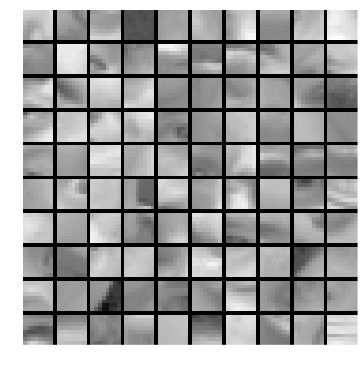

In [3]:
import pickle
dataset=pickle.load(open('cafe.pkl','r')) # or 'pofa.pkl' for POFA
NI, H, W = dataset.images.shape

N=10000  # Number of patches
p=8       # Pick p x p patches


from numpy.random import randint
X=[]
for n in range(N):
    x = randint(H-p)
    y = randint(W-p)
    X.append(dataset.images[randint(NI), x:(x+p), y:(y+p)].flatten())
             
X=asarray(X)

# Plot what some samples look like:
from dictionary_utils import to_image
plt.figure(figsize=(6,6))
plt.imshow(to_image(X[:100].reshape((100,1,p,p)), colorize=False), cmap='gray', interpolation='none')
plt.axis('off')

disp(str(X.shape))

Center the data and calculate the standard deviation:

In [4]:
X_mean = X.mean(axis=0, keepdims=True)
X_std = X.std(axis=0, keepdims=True)

And here's a helper routine we'll be using to plot the dictionaries and reconsructions based on those.

In [21]:
from dictionary_utils import to_image, activations, reconstruct
K_ = None
method_ = None
D = None

def plot_reconstructions(image_id, method, K, **other_method_params):
    # Learn the dictionaries (skip if K hasn't changed)
    global K_, method_, D
    if K != K_ or method != method_:
        K_ = K
        method_ = method
        
        fit=method(n_components=K, whiten=True, **other_method_params).fit((X-X_mean) / X_std)
        K=fit.components_.shape[0]  # ICA might change K
        D=fit.components_.reshape(K, 1, p, p)
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))

    # Plot the dictionaries learned
    axs[0].imshow(to_image(D),interpolation='none')
    axs[0].set_title('Dictionaries')
    axs[0].axis('off')

    image=dataset.images[image_id]
    image_mean = image.mean()
    image_std = image.std()

    # Plot the activation levels for the image
    S=activations((image[newaxis, newaxis, :, :] - image_mean)/image_std, D)

    axs[1].imshow(to_image(tile(swapaxes(sqrt(multiply(S,S).mean(axis=(2,3), keepdims=True)), 0, 1),(1,1,p,p)),
                            colorize=False), 
                  cmap='gray', interpolation='none')    
    axs[1].set_title('Activation Levels')
    axs[1].axis('off')
        
    # Plot the original image
    axs[2].imshow(image[(p-1):-(p-1), (p-1):-(p-1)], cmap='gray')
    axs[2].set_title('Original')
    axs[2].axis('off')

    # Plot the reconstruction
    reconstruction=(reconstruct(S, D)[0,0] * image_std ) + image_mean
    axs[3].imshow(reconstruction, cmap='gray')
    axs[3].set_title('Reconstruction')
    axs[3].axis('off')

## 1. PCA

Let's try doing the PCA and use the pricipal components as the dictionary elements.

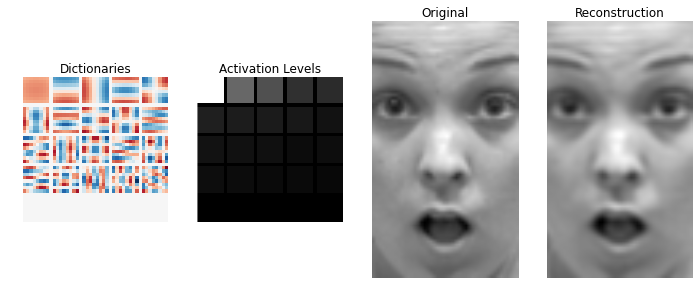

In [19]:
from sklearn.decomposition import PCA

K_ = None
method_ = None
D = None
interact(plot_reconstructions,
         method=fixed(PCA),
         image_id=(0, dataset.images.shape[0]-1),
         K=IntSlider(min=1, max=X.shape[1], value=10))

## 2. ICA

RuntimeError: error copying data to host
Apply node that caused the error: HostFromGpu(GpuCorrMM_gradInputs{valid, (1, 1)}.0)
Inputs types: [CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 10, 102, 67)]
Inputs strides: [(0, 6834, 67, 1)]
Inputs values: ['not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

<function __main__.plot_reconstructions>

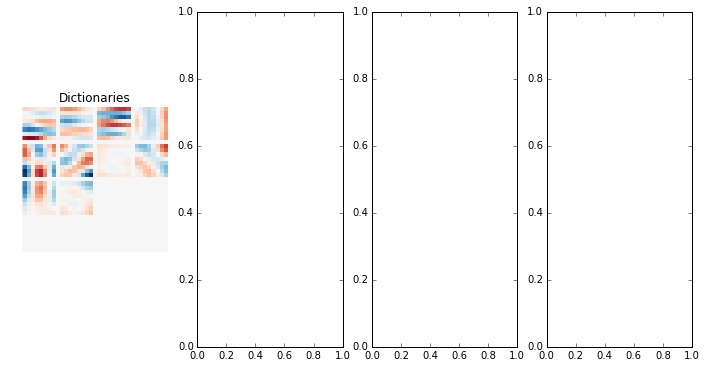

In [22]:
from sklearn.decomposition import FastICA

K_ = None
method_ = None
D = None
interact(plot_reconstructions,
         method=fixed(FastICA),
         image_id=(0, dataset.images.shape[0]-1),
         K=IntSlider(min=1, max=X.shape[1], value=10))